Here we shall implement the model of "A Neural Probabilistic Language Model" of Bengio et. al. 2003, see https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:

# load a list of popular names
words = open('names.txt','r').read().splitlines()
print(f'total of {len(words)} names')
words[:10]

total of 32033 names


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # get a sorted list of unique characters in words

# get a mapping of characters to their indices, then add start/end special token
s_to_i = {s : i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0 

# invert s_to_i
i_to_s = {i : s for s,i in s_to_i.items()}

print(i_to_s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

def build_dataset(words, block_size = 3):
    
    # block_size is the context length: number of charachters we consider to predict the next one
    X, Y = [], []

    for w in words:
        context = [0] * block_size # create the sliding window, context filled with '.'

        # loop over charachters in the word w
        for char in w + '.':
            ix = s_to_i[char] # get the index of character char
            X.append(context) # add the 
            Y.append(ix) # add char index to the sequence
    #         print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix]) # print the context and the next character
            context = context[1:] + [ix] # crop the old context and add the next character
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(.8*len(words))
n2 = int(.9*len(words))

block_size = 5

# build train, validation and test datasets
X_train, Y_train = build_dataset(words[:n1], block_size = block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size = block_size)
X_test, Y_test = build_dataset(words[n2:], block_size = block_size)

torch.Size([182625, 5]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 5]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 5]) torch.int64 torch.Size([22866]) torch.int64


In [6]:
class MLP_lang():
    
    def __init__(self, n_emb = 2, hidden_size = 200, seed = 42, block_size = 3):
        
        self.n_emb = n_emb
        self.block_size = block_size
        g = torch.Generator().manual_seed(2147483647)

        # initialise the network parameters

        C = torch.randn((len(s_to_i),n_emb), generator = g)
        W1 = torch.randn((block_size*n_emb,hidden_size), generator = g)
        W2 = torch.randn((hidden_size,len(s_to_i)), generator = g)
        b1 = torch.randn(hidden_size, generator = g)
        b2 = torch.randn(len(s_to_i), generator = g)
        
        
        
        self.parameters = [C, W1, W2, b1, b2]
        
        for k in self.parameters:
            k.requires_grad = True
        
        self.n_params = sum(k.numel() for k in self.parameters) # number of parameters
        
        # training history
        self.lossi = []
        self.stepi = []
    
    def fit(self, X_train, Y_train, lr = .01, n_epochs = 1000, verbose = False, batch_size = 32, decay = True, alpha = .5, step = 50000):
        t = time.time()
        # get the network parameters
        C = self.parameters[0]
        W1 = self.parameters[1]
        W2 = self.parameters[2]
        b1 = self.parameters[3]
        b2 = self.parameters[4]
        
        if decay == True:
            l0 = lr
        
        t_len = len(self.stepi) # number of epochs trained previously
        
        for i in range(n_epochs):

            # construct a minibatch
            ix = torch.randint(0,X_train.shape[0],(batch_size,))

            # forward pass
            emb = C[X_train[ix]] # create the embedding matrix
            h = torch.tanh(emb.view(-1,self.block_size*self.n_emb) @ W1 + b1) # hidden layer 
            logits = h @ W2 + b2 # output

            # compute the loss
            loss = F.cross_entropy(logits,Y_train[ix])
            
            if verbose:
                print(f'training loss: {loss}')

            # backward pass
            for k in self.parameters:
                k.grad = None
                
            loss.backward()
            
            if decay == True:
                lr = l0*alpha**torch.floor(torch.tensor((1 + t_len + i)//step))
                
            # update
            for k in self.parameters:
                k.data += -lr * k.grad
                
            # track the training statistics
            self.stepi.append(t_len + i)
            self.lossi.append(loss.log10().item())
            
        # save the trained model parameters
        self.parameters[0] = C
        self.parameters[1] = W1
        self.parameters[2] = W2
        self.parameters[3] = b1
        self.parameters[4] = b2

        print(f'training loss: {loss:.6f}')
        print(f'training time: {time.time()-t:.4f} seconds')
        plt.plot(self.stepi, self.lossi)
        
    def print_loss(self, X, Y,):
        
        emb = self.parameters[0][X] # create the embedding matrix
        h = torch.tanh(emb.view(-1,self.block_size*self.n_emb) @ self.parameters[1] + self.parameters[3]) # hidden layer 
        logits = h @ self.parameters[2] + self.parameters[4] # output
        loss = F.cross_entropy(logits,Y)
        print(f'loss: {loss:.6f}')
        
        
    def emb_plot(self):
        # visualize dimensions 0 and 1 of the embedding matrix C for all characters
        plt.figure(figsize = (8,8))
        plt.scatter(self.parameters[0][:,0].data, self.parameters[0][:,1].data, s = 200)
        for i in range(self.parameters[0].shape[0]):
            plt.text(self.parameters[0][i,0].item(), self.parameters[0][i,1].item(), i_to_s[i], ha = "center", va = "center", color = 'white')
        plt.grid('minor')
    
        
    def sample(self, k = 10, seed = 42):
        # sample k names from the model
        g = torch.Generator().manual_seed(seed)

        for _ in range(k):
    
            out = []
            context = [0] * self.block_size
            while True:
                emb = self.parameters[0][torch.tensor([context])] # (1,block_size,d) # embed the current context
                h = torch.tanh(emb.view(1,-1) @ self.parameters[1] + self.parameters[3])
                logits = h @ self.parameters[2] + self.parameters[4]
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
                context = context[1:] + [ix]
                out.append(ix)
                if ix == 0:
                    break
    
            print(''.join(i_to_s[i] for i in out))   

In [7]:
model = MLP_lang(n_emb = 15, hidden_size = 200, block_size = block_size)

training loss: 2.143074
training time: 205.6225 seconds
loss: 2.095236
loss: 2.099585


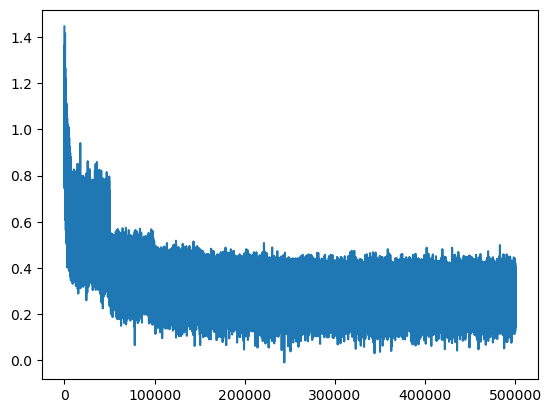

In [8]:
model.fit(X_train, Y_train, lr = .5, n_epochs = 500000, decay = True, alpha = .5, step = 50000)
model.print_loss(X_val, Y_val)
model.print_loss(X_test, Y_test)

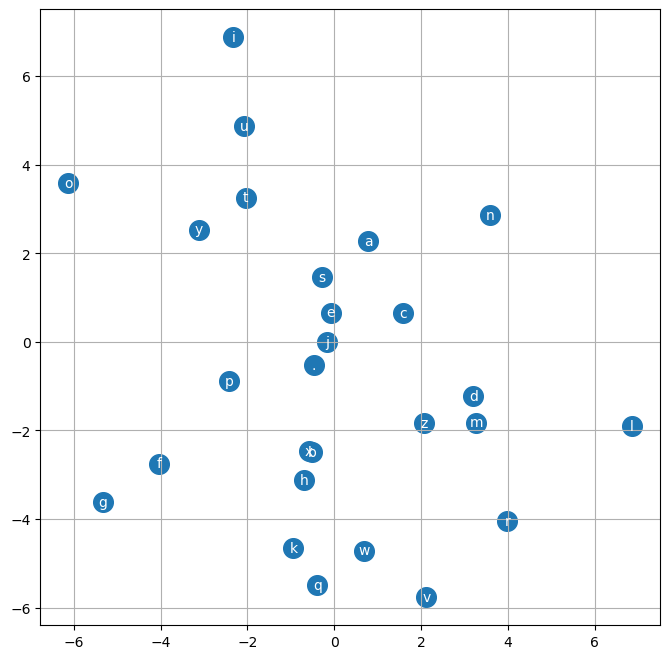

In [9]:
model.emb_plot()

In [10]:
model.sample(30)

ye.
syahle.
amen.
leekhim.
maryya.
tryvid.
chenger.
ellyanni.
eryskella.
long.
oyzae.
tywennzol.
noez.
jensen.
lamiya.
nacell.
kaylyn.
zeria.
reen.
kelsum.
ledei.
tory.
rinochan.
davyana.
breeds.
kaysyah.
thaela.
mine.
zaila.
aeleen.
